Dataset consists of two files - Training and Testing both containing a total of around ~5000 images each segregated into the severity of Alzheimer's.

Classes:
1.MildDemented
2.VeryMildDemented
3.NonDemented
4.ModerateDemeneted

In [2]:
# import system libs
import os
import cv2
import numpy as np
# import data handling tools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import plotly.express as px
from keras.preprocessing import image_dataset_from_directory

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')


modules loaded


Load the datasets

In [12]:
TRAIN_PATH = r"D:\torronto project\archive\Alzheimer_s Dataset\train"
TEST_PATH = r"D:\torronto project\archive\Alzheimer_s Dataset\test"

In [13]:
#resize the image and scale the pixel values
train_ds = image_dataset_from_directory(TRAIN_PATH, image_size=(224, 224))
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))

test_ds = image_dataset_from_directory(TEST_PATH, image_size=(224, 224), shuffle=False)
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))

Found 5121 files belonging to 4 classes.
Found 1279 files belonging to 4 classes.


2


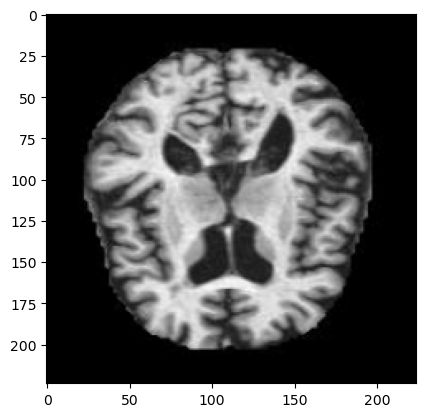

In [14]:
#Plot for a sinlge image
for step, img in enumerate(train_ds):
    
    print(img[1].numpy()[0])
    plt.imshow(img[0][0])
    plt.show()
    
    break
# 2 is label for the image

Count images in each class for train and test datasets

In [15]:
# Get class names
class_names = os.listdir(TRAIN_PATH)

# Create dictionaries to store counts
train_class_counts = {class_name: 0 for class_name in class_names}
test_class_counts = {class_name: 0 for class_name in class_names}

# Count samples for each class in the train dataset
for class_name in class_names:
    class_path = os.path.join(TRAIN_PATH, class_name)
    train_class_counts[class_name] = len(os.listdir(class_path))

# Count samples for each class in the test dataset
for class_name in class_names:
    class_path = os.path.join(TEST_PATH, class_name)
    test_class_counts[class_name] = len(os.listdir(class_path))

# Print counts
print("Train Class Counts:", train_class_counts)
print("Test Class Counts:", test_class_counts)


Train Class Counts: {'MildDemented': 717, 'ModerateDemented': 52, 'NonDemented': 2560, 'VeryMildDemented': 1792}
Test Class Counts: {'MildDemented': 179, 'ModerateDemented': 12, 'NonDemented': 640, 'VeryMildDemented': 448}


In [16]:
# Create bar plots using Plotly
fig_train = px.bar(x=list(train_class_counts.keys()), y=list(train_class_counts.values()), 
                   title="Train Class Counts")
fig_train.update_xaxes(title_text=None)
fig_train.update_yaxes(title_text='Counts')
fig_train.show()

fig_test = px.bar(x=list(test_class_counts.keys()), y=list(test_class_counts.values()), 
                  title="Test Class Counts")
fig_test.update_xaxes(title_text=None)
fig_test.update_yaxes(title_text='Counts')

The data is heavily imbalanced, need to create a balanced dataset

Let's see images corresponding to different classes

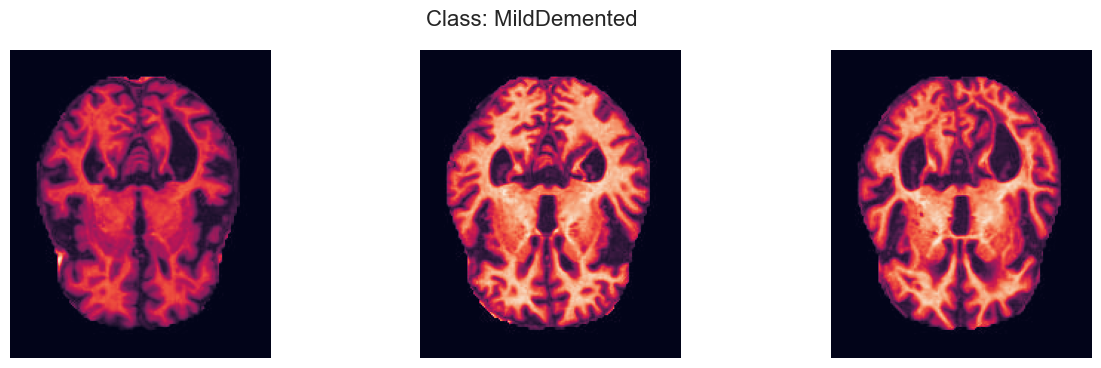

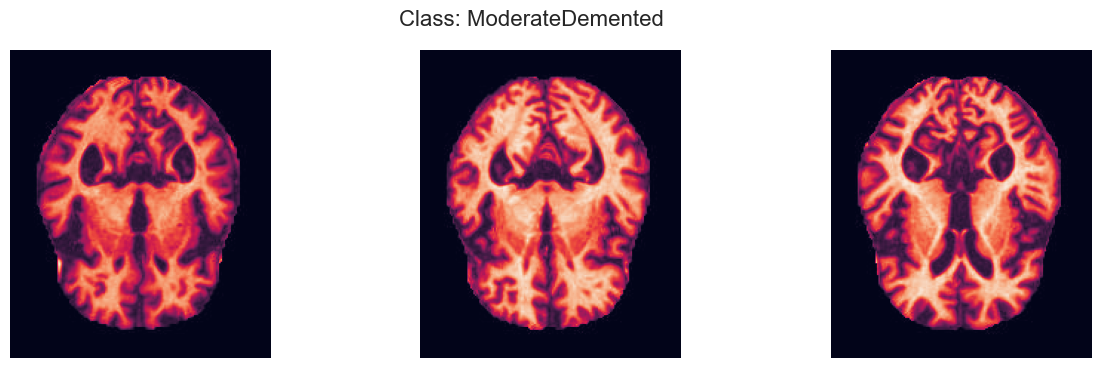

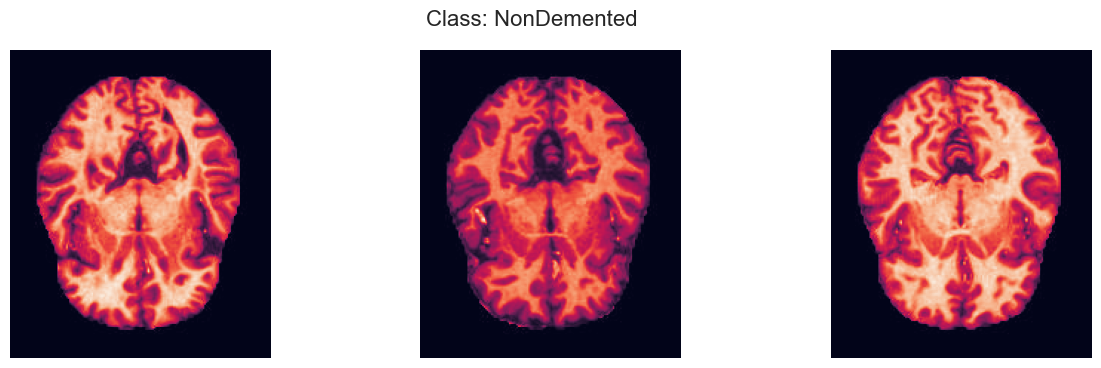

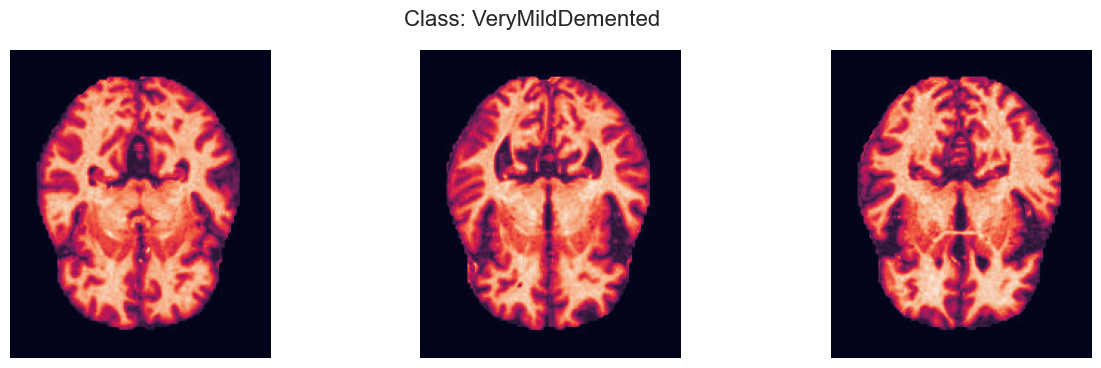

In [15]:
# Specify the number of images to display per class
num_images_per_class = 3

# Display sample images
for class_name in class_names:
    class_path = os.path.join(TRAIN_PATH, class_name)
    image_files = os.listdir(class_path)[:num_images_per_class]

    plt.figure(figsize=(15, 4))
    plt.suptitle(f"Class: {class_name}", fontsize=16)

    for i, image_file in enumerate(image_files):
        img_path = os.path.join(class_path, image_file)
        plt.subplot(1, num_images_per_class, i + 1)
        plt.imshow(mpimg.imread(img_path))
        plt.axis("off")

    plt.show()

Let's create a balanced dataset using Image generator

In [2]:
#Load all the class folders separately from train folder
mild_demented_folder = os.path.join(r"D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented")
moderate_demented_folder = os.path.join(r"D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented")
non_demented_folder = os.path.join(r"D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented")
very_mild_demented_folder = os.path.join(r"D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented")

In [3]:
#define folders for saving the augmented images
mild_demented_save_folder = r"D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented"
moderate_demented_save_folder = r"D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented"
non_demented_save_folder = r"D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented"
very_mild_demented_save_folder = r"D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented"

In [4]:
#Define Image generator
from keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, 
    height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
    channel_shift_range=10., horizontal_flip=True)

In [17]:
def load_and_augment_data(class_folder, save_folder, num_samples=3000):
    # Create the save folder if it doesn't exist
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
        print(f"Created folder: {save_folder}")

    # Loading the original images
    original_images = []
    for image_file in os.listdir(class_folder):
        image_path = os.path.join(class_folder, image_file)
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        resized_image = cv2.resize(image_rgb, (224, 224))
        original_images.append(resized_image)

    # Converting to numpy array
    original_images = np.array(original_images)

    # Augmentation
    aug_images = []
    for i in range(original_images.shape[0]):
        image = original_images[i]
        image = np.expand_dims(image, 0)
        aug_iter = gen.flow(image)
        for j in range(4):
            augmented_image = next(aug_iter)[0].astype(np.uint8)
            aug_images.append(augmented_image)

    # Determine how many additional samples are needed
    num_samples_needed = num_samples - original_images.shape[0]

    # Apply additional augmentation
    for _ in range(num_samples_needed // original_images.shape[0]):
        for i in range(original_images.shape[0]):
            image = original_images[i]
            image = np.expand_dims(image, 0)
            aug_iter = gen.flow(image)
            for j in range(4):
                augmented_image = next(aug_iter)[0].astype(np.uint8)
                aug_images.append(augmented_image)

    aug_images = np.array(aug_images)
    augmented_class_images = np.concatenate((original_images, aug_images), axis=0)

    # Save augmented images to disk
    for idx, augmented_image in enumerate(augmented_class_images):
        if idx >= num_samples:  # Stop saving after reaching the desired number of images
            break

        filename = f"{idx + 1}.jpg"
        save_path = os.path.join(save_folder, filename)

        try:
            cv2.imwrite(save_path, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))
            print(f"Saved image: {save_path}")
        except Exception as e:
            print(f"Error saving image {filename}: {e}")

    return augmented_class_images[:num_samples]


In [18]:
#Very mild demented images
augmented_very_mild_demented_images = load_and_augment_data(very_mild_demented_folder, very_mild_demented_save_folder)

print("Augmented Very Mild Demented images shape:", augmented_very_mild_demented_images.shape)

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\1.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\2.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\3.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\4.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\5.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\6.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\7.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\8.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\9.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\10.jpg

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\198.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\199.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\200.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\201.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\202.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\203.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\204.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\205.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\206.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemente

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\387.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\388.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\389.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\390.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\391.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\392.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\393.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\394.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\395.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemente

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\607.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\608.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\609.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\610.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\611.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\612.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\613.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\614.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\615.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemente

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\855.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\856.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\857.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\858.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\859.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\860.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\861.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\862.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\863.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemente

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\1120.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\1121.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\1122.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\1123.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\1124.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\1125.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\1126.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\1127.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\1128.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMi

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\1447.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\1448.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\1449.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\1450.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\1451.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\1452.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\1453.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\1454.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\1455.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMi

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\1776.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\1777.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\1778.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\1779.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\1780.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\1781.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\1782.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\1783.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\1784.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMi

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\2111.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\2112.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\2113.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\2114.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\2115.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\2116.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\2117.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\2118.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\2119.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMi

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\2444.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\2445.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\2446.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\2447.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\2448.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\2449.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\2450.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\2451.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\2452.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMi

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\2778.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\2779.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\2780.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\2781.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\2782.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\2783.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\2784.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\2785.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMildDemented_augmented\2786.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\VeryMi

Augmented Very Mild Demented images shape: (3000, 224, 224, 3)


In [19]:
# Call the function for MildDemented class
augmented_mild_demented_images = load_and_augment_data(mild_demented_folder, mild_demented_save_folder)

# Print the shape
print("Augmented Mild Demented images shape:", augmented_mild_demented_images.shape)

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\2.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\3.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\4.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\5.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\6.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\7.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\8.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\9.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\10.jpg
Saved image: D:\torronto project\archiv

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\206.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\207.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\208.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\209.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\210.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\211.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\212.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\213.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\214.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\215.jpg
Saved image: D:\torr

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\362.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\363.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\364.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\365.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\366.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\367.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\368.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\369.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\370.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\371.jpg
Saved image: D:\torr

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\530.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\531.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\532.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\533.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\534.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\535.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\536.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\537.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\538.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\539.jpg
Saved image: D:\torr

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\679.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\680.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\681.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\682.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\683.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\684.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\685.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\686.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\687.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\688.jpg
Saved image: D:\torr

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\824.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\825.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\826.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\827.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\828.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\829.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\830.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\831.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\832.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\833.jpg
Saved image: D:\torr

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1008.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1009.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1010.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1011.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1012.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1013.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1014.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1015.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1016.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1017.jpg
Saved imag

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1199.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1200.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1201.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1202.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1203.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1204.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1205.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1206.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1207.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1208.jpg
Saved imag

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1381.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1382.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1383.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1384.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1385.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1386.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1387.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1388.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1389.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1390.jpg
Saved imag

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1565.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1566.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1567.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1568.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1569.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1570.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1571.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1572.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1573.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1574.jpg
Saved imag

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1738.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1739.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1740.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1741.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1742.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1743.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1744.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1745.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1746.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1747.jpg
Saved imag

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1952.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1953.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1954.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1955.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1956.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1957.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1958.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1959.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1960.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\1961.jpg
Saved imag

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\2172.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\2173.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\2174.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\2175.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\2176.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\2177.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\2178.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\2179.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\2180.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\2181.jpg
Saved imag

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\2420.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\2421.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\2422.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\2423.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\2424.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\2425.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\2426.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\2427.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\2428.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\2429.jpg
Saved imag

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\2672.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\2673.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\2674.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\2675.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\2676.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\2677.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\2678.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\2679.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\2680.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\2681.jpg
Saved imag

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\2902.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\2903.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\2904.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\2905.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\2906.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\2907.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\2908.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\2909.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\2910.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\MildDemented_augmented\2911.jpg
Saved imag

Augmented Mild Demented images shape: (3000, 224, 224, 3)


In [20]:
# Call the function for NonDemented class
augmented_non_demented_images = load_and_augment_data(non_demented_folder, non_demented_save_folder)

# Print the shape
print("Augmented Non Demented images shape:", augmented_non_demented_images.shape)

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\1.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\3.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\4.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\5.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\6.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\7.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\8.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\9.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\10.jpg
Saved image: D:\torronto project\archive\Alzheime

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\248.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\249.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\250.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\251.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\252.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\253.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\254.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\255.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\256.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\257.jpg
Saved image: D:\torronto proje

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\483.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\484.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\485.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\486.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\487.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\488.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\489.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\490.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\491.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\492.jpg
Saved image: D:\torronto proje

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\685.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\686.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\687.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\688.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\689.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\690.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\691.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\692.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\693.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\694.jpg
Saved image: D:\torronto proje

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\893.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\894.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\895.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\896.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\897.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\898.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\899.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\900.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\901.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\902.jpg
Saved image: D:\torronto proje

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\1132.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\1133.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\1134.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\1135.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\1136.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\1137.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\1138.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\1139.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\1140.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\1141.jpg
Saved image: D:\torr

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\1372.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\1373.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\1374.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\1375.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\1376.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\1377.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\1378.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\1379.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\1380.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\1381.jpg
Saved image: D:\torr

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\1606.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\1607.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\1608.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\1609.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\1610.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\1611.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\1612.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\1613.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\1614.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\1615.jpg
Saved image: D:\torr

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\1809.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\1810.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\1811.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\1812.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\1813.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\1814.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\1815.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\1816.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\1817.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\1818.jpg
Saved image: D:\torr

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2021.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2022.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2023.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2024.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2025.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2026.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2027.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2028.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2029.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2030.jpg
Saved image: D:\torr

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2264.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2265.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2266.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2267.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2268.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2269.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2270.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2271.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2272.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2273.jpg
Saved image: D:\torr

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2499.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2500.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2501.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2502.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2503.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2504.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2505.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2506.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2507.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2508.jpg
Saved image: D:\torr

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2741.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2742.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2743.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2744.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2745.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2746.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2747.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2748.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2749.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2750.jpg
Saved image: D:\torr

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2985.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2986.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2987.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2988.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2989.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2990.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2991.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2992.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2993.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\NonDemented_augmented\2994.jpg
Saved image: D:\torr

In [21]:
# Call the function for ModerateDemented class
augmented_moderate_demented_images = load_and_augment_data(moderate_demented_folder, moderate_demented_save_folder)

# Print the shape
print("Augmented Moderate Demented images shape:", augmented_moderate_demented_images.shape)

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\1.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\2.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\3.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\4.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\5.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\6.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\7.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\8.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\9.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\10.jpg

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\276.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\277.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\278.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\279.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\280.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\281.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\282.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\283.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\284.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemente

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\549.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\550.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\551.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\552.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\553.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\554.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\555.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\556.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\557.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemente

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\816.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\817.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\818.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\819.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\820.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\821.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\822.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\823.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\824.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemente

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\1091.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\1092.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\1093.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\1094.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\1095.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\1096.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\1097.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\1098.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\1099.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\Modera

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\1383.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\1384.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\1385.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\1386.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\1387.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\1388.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\1389.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\1390.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\1391.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\Modera

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\1709.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\1710.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\1711.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\1712.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\1713.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\1714.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\1715.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\1716.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\1717.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\Modera

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\2019.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\2020.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\2021.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\2022.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\2023.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\2024.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\2025.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\2026.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\2027.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\Modera

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\2329.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\2330.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\2331.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\2332.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\2333.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\2334.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\2335.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\2336.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\2337.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\Modera

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\2655.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\2656.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\2657.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\2658.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\2659.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\2660.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\2661.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\2662.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\2663.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\Modera

Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\2975.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\2976.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\2977.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\2978.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\2979.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\2980.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\2981.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\2982.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\ModerateDemented_augmented\2983.jpg
Saved image: D:\torronto project\archive\Alzheimer_s Dataset\train\Modera